Below you can find a simple neural network code that you will use to train the autoencoder. Create a copy of this notebook for running the tests.

You must implement your own data loading code. The dataset should be:
* Loaded from the provided Kaggle dataset
* 32x32 images should be converted to 28x28 by removing the padding (Refer dataset)
* 28x28 images to be flattened as 784-dimensional vectors
* Normalized and Split appropriately into training and testing sets

You will need to write the training loop as well. We recommend you also do csv logging for the various metrics such as loss, train and test accuracy so that you can see the trends at different epochs. The logs are for your own reference and for helping you make graphs and need not be submitted

The Goal of this homework is not to assess your coding capabilities and is more intended as an exploration of the concept of auto encoders. Consequently you are allowed to use Generative models to assist you in the coding process. Do reference the models you have used for portions of the code as comments within the code

In [ ]:
!unzip archive\ \(5\).zip

Streaming output truncated to the last 5000 lines.
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10300.png  
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10301.png  
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10302.png  
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10303.png  
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10304.png  
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10306.png  
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit_7/10307.png  
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit_7/104017.png  
  inflating: DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Train/digit

In [ ]:
import pandas as pd
import cv2
import numpy as np
import os

df = pd.read_csv('hindi_mnist.csv')

train_df = df[df['filename'].str.contains('/Train/')].reset_index(drop=True)
test_df = df[df['filename'].str.contains('/Test/')].reset_index(drop=True)

# Extract labels
y_train = train_df['label'].values
y_test = test_df['label'].values

def load_and_preprocess_images(df, base_path):
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_path, row['filename'])

        # Read the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        img_resized = img[2:30, 2:30]

        img_flattened = img_resized.flatten()

        images.append(img_flattened)

    return np.array(images)

base_path = 'DevanagariHandwrittenDigitDataset/'

X_train = load_and_preprocess_images(train_df, base_path)
X_test = load_and_preprocess_images(test_df, base_path)

# Normalize the pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17000, 784)
y_train shape: (17000,)
X_test shape: (3000, 784)
y_test shape: (3000,)


In [ ]:
import matplotlib.pyplot as plt

class NeuralNetwork:

    def __init__(self, input_size, output_size, hidden_layer_sizes, optimizer='adam'):
        self.layer_sizes = [input_size] + hidden_layer_sizes + [output_size]
        self.weights = []
        self.biases = []
        for layer_index in range(len(self.layer_sizes) - 1):
            self.weights.append(
                np.random.randn(self.layer_sizes[layer_index], self.layer_sizes[layer_index + 1])
                * np.sqrt(2. / self.layer_sizes[layer_index])
            )
            self.biases.append(np.zeros(self.layer_sizes[layer_index + 1]))

        self.optimizer = optimizer
        self.initialize_optimizer()

    def initialize_optimizer(self):
        if self.optimizer == 'adam':
            self.momentum_weights = [np.zeros_like(weight) for weight in self.weights]
            self.velocity_weights = [np.zeros_like(weight) for weight in self.weights]
            self.momentum_biases = [np.zeros_like(bias) for bias in self.biases]
            self.velocity_biases = [np.zeros_like(bias) for bias in self.biases]
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.time_step = 0

    def relu(self, input_value):
        return np.maximum(0, input_value)

    def relu_derivative(self, input_value):
        return (input_value > 0).astype(float)

    def sigmoid(self, input_value):
        return 1 / (1 + np.exp(-input_value))

    def compute_loss(self, true_labels, predicted_labels):
        return np.mean((true_labels - predicted_labels) ** 2)

    def forward_propagation(self, input_data):
        activations = [input_data]
        pre_activations = []

        for layer_index in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[layer_index]) + self.biases[layer_index]
            pre_activations.append(z)
            if layer_index == len(self.weights) - 1:
                activation = self.sigmoid(z)
            else:
                activation = self.relu(z)
            activations.append(activation)

        return activations, pre_activations

    def backpropagation(self, input_data, true_labels, activations, pre_activations):
        num_samples = true_labels.shape[0]
        deltas = [None] * len(self.weights)
        gradients_weights = [None] * len(self.weights)
        gradients_biases = [None] * len(self.biases)

        # Output layer delta (sigmoid derivative)
        deltas[-1] = (activations[-1] - true_labels) * (activations[-1] * (1 - activations[-1]))

        # Hidden layers delta
        for layer_index in reversed(range(len(deltas) - 1)):
            deltas[layer_index] = np.dot(deltas[layer_index + 1], self.weights[layer_index + 1].T) * self.relu_derivative(pre_activations[layer_index])

        # Gradients
        for layer_index in range(len(self.weights)):
            gradients_weights[layer_index] = np.dot(activations[layer_index].T, deltas[layer_index]) / num_samples
            gradients_biases[layer_index] = np.sum(deltas[layer_index], axis=0) / num_samples

        return gradients_weights, gradients_biases

    def update_parameters(self, gradients_weights, gradients_biases, learning_rate):
        if self.optimizer == 'adam':
            self.time_step += 1
            for layer_index in range(len(self.weights)):
                # Update biased first moments
                self.momentum_weights[layer_index] = self.beta1 * self.momentum_weights[layer_index] + (1 - self.beta1) * gradients_weights[layer_index]
                self.momentum_biases[layer_index] = self.beta1 * self.momentum_biases[layer_index] + (1 - self.beta1) * gradients_biases[layer_index]

                # Update biased second moments
                self.velocity_weights[layer_index] = self.beta2 * self.velocity_weights[layer_index] + (1 - self.beta2) * (gradients_weights[layer_index] ** 2)
                self.velocity_biases[layer_index] = self.beta2 * self.velocity_biases[layer_index] + (1 - self.beta2) * (gradients_biases[layer_index] ** 2)

                # Correct bias
                corrected_momentum_weights = self.momentum_weights[layer_index] / (1 - self.beta1 ** self.time_step)
                corrected_momentum_biases = self.momentum_biases[layer_index] / (1 - self.beta1 ** self.time_step)

                corrected_velocity_weights = self.velocity_weights[layer_index] / (1 - self.beta2 ** self.time_step)
                corrected_velocity_biases = self.velocity_biases[layer_index] / (1 - self.beta2 ** self.time_step)

                # Update parameters
                self.weights[layer_index] -= learning_rate * corrected_momentum_weights / (np.sqrt(corrected_velocity_weights) + self.epsilon)
                self.biases[layer_index] -= learning_rate * corrected_momentum_biases / (np.sqrt(corrected_velocity_biases) + self.epsilon)
        else:
            for layer_index in range(len(self.weights)):
                self.weights[layer_index] -= learning_rate * gradients_weights[layer_index]
                self.biases[layer_index] -= learning_rate * gradients_biases[layer_index]

    def train(self, input_data, true_labels, epochs, learning_rate, batch_size):

        num_samples = input_data.shape[0]
        loss_history = []  # To store loss for each epoch
        min_loss = 1e9 # for early stopping
        patience = 15
        counter = 0

        print("Starting training...")
        for epoch in range(epochs):
            # Shuffle data for each epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            input_shuffled = input_data[indices]
            # For an autoencoder, the "labels" are the inputs themselves
            labels_shuffled = input_data[indices]

            # Process data in batches
            for batch_start in range(0, num_samples, batch_size):
                input_batch = input_shuffled[batch_start:batch_start + batch_size]
                labels_batch = labels_shuffled[batch_start:batch_start + batch_size]

                activations, pre_activations = self.forward_propagation(input_batch)
                gradients_weights, gradients_biases = self.backpropagation(input_batch, labels_batch, activations, pre_activations)
                self.update_parameters(gradients_weights, gradients_biases, learning_rate)

            # Calculate and store loss for the epoch
            reconstructed_output = self.forward_propagation(input_data)[0][-1]
            train_loss = self.compute_loss(input_data, reconstructed_output)
            if train_loss < min_loss:
                min_loss = train_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}.")
                    break

            loss_history.append(train_loss)

            print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.6f}")

        print("Training complete.")
        return loss_history

    def reconstruct(self, input_data):
        activations, _ = self.forward_propagation(input_data)
        return activations[-1]





In [ ]:
from PIL import Image
from sklearn.decomposition import PCA

def reconstruct_with_pca(data, n_components):
    pca = PCA(n_components=n_components)
    data_reduced = pca.fit_transform(data)
    data_reconstructed = pca.inverse_transform(data_reduced)

    print(f"Data reconstructed using PCA with {n_components} components.")
    return data_reconstructed

def save_reconstructed_image(flattened_image, filename = "output.png", width=28, height=28):

    # Reshape and scale pixel values back to 0-255
    image_array = flattened_image.reshape(height, width) * 255.0

    # Convert to an 8-bit integer format and create an image
    image = Image.fromarray(image_array.astype(np.uint8))

    # Save the image
    image.save(filename)
    print(f"Saved image to {filename}")

def plot_training_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.grid(True)
    plt.show()

In [ ]:
# Network Architecture
input_size = 784  # 28x28 flattened
output_size = 784  # Same as input for autoencoder
hidden_layers = [784, 392, 196, 98, 49, 24, 16, 24, 49, 98, 196, 392, 784]

# Training Parameters
learning_rate = 0.001
epochs = 400
batch_size = 256
np.random.seed(42)  # For reproducibility

In [ ]:
Autoencoder = NeuralNetwork(input_size, output_size, hidden_layers, optimizer='adam')
loss_history = Autoencoder.train(X_train, X_train, epochs, learning_rate, batch_size)

Starting training...
Epoch 1/400, Training Loss: 0.120438
Epoch 2/400, Training Loss: 0.092922
Epoch 3/400, Training Loss: 0.081900
Epoch 4/400, Training Loss: 0.075280
Epoch 5/400, Training Loss: 0.071005
Epoch 6/400, Training Loss: 0.066331
Epoch 7/400, Training Loss: 0.064544
Epoch 8/400, Training Loss: 0.060369
Epoch 9/400, Training Loss: 0.059316
Epoch 10/400, Training Loss: 0.057111
Epoch 11/400, Training Loss: 0.055596
Epoch 12/400, Training Loss: 0.052884
Epoch 13/400, Training Loss: 0.051390
Epoch 14/400, Training Loss: 0.050824
Epoch 15/400, Training Loss: 0.049551
Epoch 16/400, Training Loss: 0.047907
Epoch 17/400, Training Loss: 0.046815
Epoch 18/400, Training Loss: 0.045681
Epoch 19/400, Training Loss: 0.044557
Epoch 20/400, Training Loss: 0.043689
Epoch 21/400, Training Loss: 0.042796
Epoch 22/400, Training Loss: 0.041796
Epoch 23/400, Training Loss: 0.041856
Epoch 24/400, Training Loss: 0.041604
Epoch 25/400, Training Loss: 0.039938
Epoch 26/400, Training Loss: 0.039700


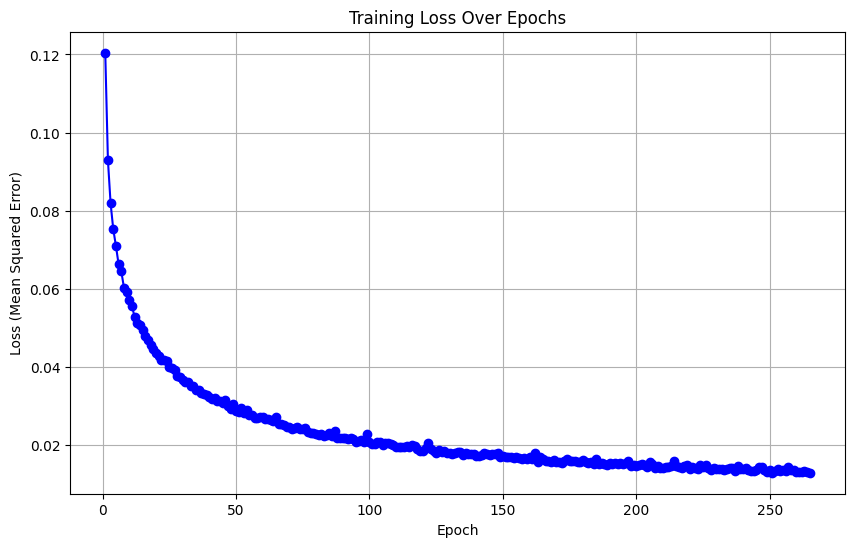


Final Test Loss: 0.043002
Data reconstructed using PCA with 32 components.
Saved image to original_image_1.png
Saved image to reconstruction_of_1.png
Saved image to original_image_5.png
Saved image to reconstruction_of_5.png
Saved image to original_image_6.png
Saved image to reconstruction_of_6.png
Saved image to original_image_7.png
Saved image to reconstruction_of_7.png
Saved image to original_image_9.png
Saved image to reconstruction_of_9.png


In [ ]:



plot_training_loss(loss_history)

test_reconstructions = Autoencoder.reconstruct(X_test)
test_loss = Autoencoder.compute_loss(X_test, test_reconstructions)
print(f"\nFinal Test Loss: {test_loss:.6f}")

# VISUALIZE AUTOENCODER RECONSTRUCTION

sample_index = 24
test_numbers = [1, 5, 6, 7, 9] # most complicated ones
pca_reconstructions = reconstruct_with_pca(X_test, n_components=32)
for i in test_numbers:
  original_image = X_test[sample_index + 300*i]
  # reconstructed_image = test_reconstructions[sample_index + 300*i]
  reconstructed_image = pca_reconstructions[sample_index + 300*i]
  save_reconstructed_image(original_image, f"original_image_{i}.png")
  save_reconstructed_image(reconstructed_image, f"reconstruction_of_{i}.png")


